### This tutorial takes you through the basics of analysing Mitty data with some help from cytoolz and pandas

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import matplotlib.pyplot as plt
import cytoolz.curried as cyt
from bokeh.plotting import figure, show, output_file

In [3]:
import mitty.analysis.bam as mab
import mitty.analysis.plots as mapl

In [4]:
fname = '../mitty-demo-data/alignment-accuracy/HG00119-bwa.bam'
scar_fname = '../mitty-demo-data/generating-reads/HG00119-reads-corrupt-lq.txt'

Ex1
---
Simple example showing reading from a BAM and writing out to another BAM

1. Reading from a BAM
2. Write out to another BAM

In [119]:
r1 = mab.read_bam(bam_fname=fname, sidecar_fname=None)
r2 = mab.write_bam('eraseme.bam', mab.get_header(fname))

for r in cyt.pipe(r1, r2, cyt.take(20)):
    pass

Ex2
---
More involved example showing, in sequence:

1. Reading from a BAM
2. Compute d_err for the reads
3. Categorize reads based on d_err
4. Count reads in each category
5. Pairing up of reads
6. Filter to keep non-reference reads only. Keep a pair only if both reads are non-ref
7. Re-Categorize reads based on d_err
8. Re-Count reads in each category

At the end the category counts are comparatively plotted.

In [7]:
r1 = mab.read_bam(bam_fname=fname, sidecar_fname=scar_fname)
r2 = mab.compute_derr(max_d=200)

f_dict = {
    'd = 0': lambda mate: mate['d_err'] == 0,
    '0 < d <= 50': lambda mate: 0 < mate['d_err'] <= 50,
    '50 < d': lambda mate: 50 < mate['d_err'] < 200,
    'WC': lambda mate: 200 < mate['d_err'],
    'UM': lambda mate: mate['read'].is_unmapped
}
r3 = mab.categorize_reads(f_dict)
all_counts = {}
r4 = mab.count_reads(all_counts) 
r5 = mab.make_pairs
r6 = mab.filter_reads(mab.non_ref(), all)
r7 = mab.categorize_reads(f_dict)
nr_counts = {}
r8 = mab.count_reads(nr_counts)

for r in cyt.pipe(r1, r2, r3, r4, r5, r6, r7, r8):
    pass

The new concept here is the use of a dictionary of filters to supply to the categorization function. The result is stored in the `all_counts` and `nr_counts` dictionaries which need to be preallocated and passed to the counting function which modifes them.

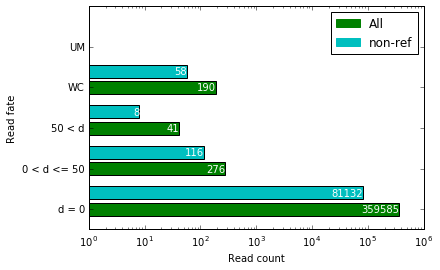

In [8]:
mapl.plot_read_counts(ax=plt.subplot(1, 1, 1), 
                      counts_l=[all_counts, nr_counts],
                      labels=['All', 'non-ref'],
                      keys=['d = 0', '0 < d <= 50', '50 < d', 'WC', 'UM'], 
                      colors=None)
plt.show()

Ex3
---
Alignment metrics plotting example

1. Read BAMs
2. Compute PairedAlignmentHistogram
3. Plot slices of the alignment

In [50]:
h = mab.PairedAlignmentHistogram(max_d=max_d, buf_size=1000000)
h

0| xd1	|alignment error mate 1             |   15 bins
1| xd2	|alignment error mate 2             |   15 bins
2| mq1	|mapping quality mate 1             |    5 bins
3| mq2	|mapping quality mate 2             |    5 bins
4| v1	|length of variant carried by mate 1|    7 bins
5| v2	|length of variant carried by mate 2|    7 bins
6| xt	|template length error              |   13 bins
7| t	|Correct template length            |    5 bins

In [37]:
max_d = 200
r1 = mab.read_bam(bam_fname=fname, sidecar_fname=scar_fname)
r2 = mab.compute_derr(max_d=max_d)
r3 = mab.make_pairs
# pah = mab.PairedAlignmentHistogram(max_d=max_d, buf_size=1000000)

p1 = mab.initialize_pah(name='FullHist')
mab.histogramize(pah=p1)(cyt.pipe(r1, cyt.take(1000), r2, r3))
mab.save_pah(p1, 'test_hist.pklz')

In [39]:
p1_l = mab.load_pah('test_hist.pklz')

In [40]:
p1_l

<xarray.DataArray 'FullHist' (xd1: 15, xd2: 15, mq1: 5, mq2: 5, v1: 7, v2: 7, xt: 13, t: 5)>
array([[[[[[[[0, ..., 0],
             ..., 
             [0, ..., 0]],

            ..., 
            [[0, ..., 0],
             ..., 
             [0, ..., 0]]],


           ..., 
           [[[0, ..., 0],
             ..., 
             [0, ..., 0]],

            ..., 
            [[0, ..., 0],
             ..., 
             [0, ..., 0]]]],



          ..., 
          [[[[0, ..., 0],
             ..., 
             [0, ..., 0]],

            ..., 
            [[0, ..., 0],
             ..., 
             [0, ..., 0]]],


           ..., 
           [[[0, ..., 0],
             ..., 
             [0, ..., 0]],

            ..., 
            [[0, ..., 0],
             ..., 
             [0, ..., 0]]]]],




         ..., 
         [[[[[0, ..., 0],
             ..., 
             [0, ..., 0]],

            ..., 
            [[0, ..., 0],
             ..., 
             [0, ..., 0]]],


      

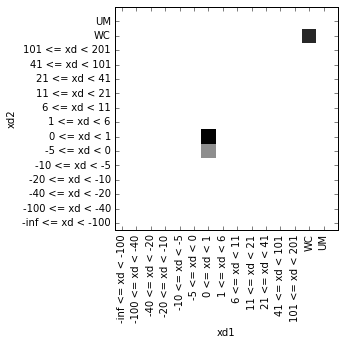

In [45]:
p2 = mab.collapse(p1, xd1=None, xd2=None)
mab.plot_hist(p2)
plt.show()

In [53]:
p1.coords['v1']

<xarray.DataArray 'v1' (v1: 7)>
array(['-inf <= V < -20', '-20 <= V < 0', '0 <= V < 1', '1 <= V < 21',
       '21 <= V < 23', 'Ref', 'V+'], 
      dtype='<U15')
Coordinates:
  * v1       (v1) <U15 '-inf <= V < -20' '-20 <= V < 0' '0 <= V < 1' ...

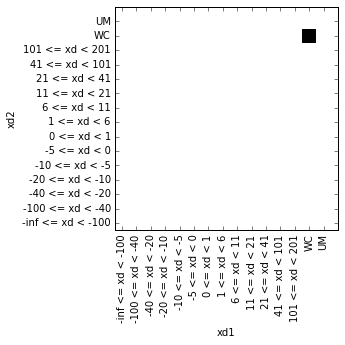

In [58]:
p2 = mab.collapse(p1, xd1=None, xd2=None, v1=(1, 2), v2=(5, 6))
mab.plot_hist(p2)
plt.show()

In [59]:
p2

<xarray.DataArray 'FullHist' (xd1: 15, xd2: 15)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * xd1      (xd1) <U17 '-inf <= xd < -100' '-100 <= xd < -40' ...
  * xd2      (xd2) <U17 '-inf <= xd < -100' '-100 <= xd < -40' ...

In [ ]:
import pickle
pickle.dump(p1, open('test_hist.pkl', 'wb'), protocol=-1)

In [ ]:
p1.to_netcdf('test_hist.cdf', engine='scipy')

In [97]:
p2 = mab.collapse(p1, 'xd1', 'xd2')
p2

<xarray.DataArray 'TestHist' (xd1: 15, xd2: 15)>
array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ..., 
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0, 82,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])
Coordinates:
  * xd1      (xd1) <U17 '-inf <= xd < -100' '-100 <= xd < -40' ...
  * xd2      (xd2) <U17 '-inf <= xd < -100' '-100 <= xd < -40' ...

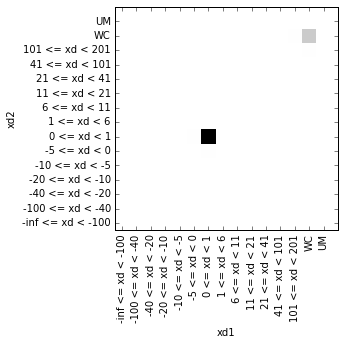

In [131]:
mab.plot_hist(p2)
plt.show()

In [122]:
p2.coords[p2.dims[0]].values

array(['-inf <= xd < -100', '-100 <= xd < -40', '-40 <= xd < -20',
       '-20 <= xd < -10', '-10 <= xd < -5', '-5 <= xd < 0', '0 <= xd < 1',
       '1 <= xd < 6', '6 <= xd < 11', '11 <= xd < 21', '21 <= xd < 41',
       '41 <= xd < 101', '101 <= xd < 201', 'WC', 'UM'], 
      dtype='<U17')

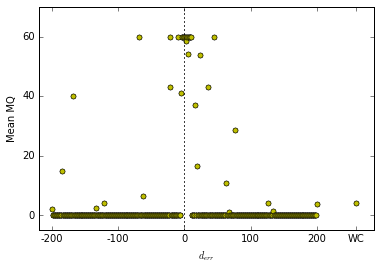

In [105]:
ax = plt.subplot(1,1,1)
mapl.plot_mean_MQ_vs_derr(ax=ax, dmv_mat=dmv_mat, fmt='yo', ms=5)
plt.show()

In [72]:
p1 = mab.initialize_pah()

In [74]:
len(p1.coords)

8

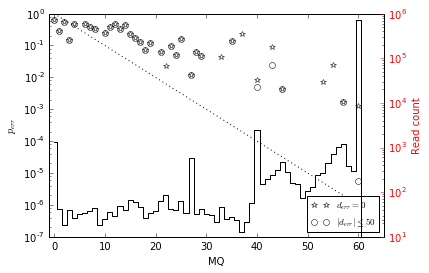

In [149]:
ax1 = plt.subplot(1,1,1)
mapl.plot_perr_vs_MQ(ax=ax1, dmv_mat=dmv_mat, yscale='log')
ax2 = ax1.twinx()
mapl.plot_read_count_vs_MQ(ax=ax2, dmv_mat=dmv_mat)
ax2.set_ylabel('Read count', color='r')
ax2.tick_params('y', colors='r')
ax1.legend(loc='lower right', fontsize=9)
plt.show()

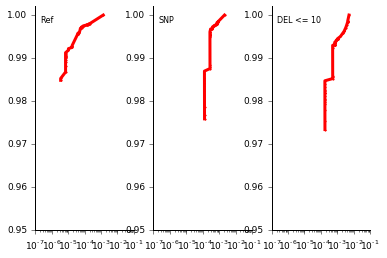

In [117]:
for n, v_bin_label in enumerate(
    ['Ref', 'SNP', 'DEL <= 10']):
    ax = plt.subplot(1, 3, n + 1)
    mapl.hengli_plot(ax=ax, dmv_mat=dmv_mat, v_bin_label=v_bin_label)
plt.show()

Ex4: Dataframes
--------------

In [150]:
r1 = mab.read_bam(bam_fname=fname, sidecar_fname=scar_fname)
r2 = mab.compute_derr(max_d=200)
r3 = mab.to_df(tags=['NM'])
df = cyt.pipe(r1, r2, cyt.take(20), r3)
df

,qname,mate,chrom,pos,cigar,MQ,d_err,correct_chrom,correct_pos,correct_cigar,NM
0,3E78,2,1,13655999,148M102S,0,201,20,2805905,250=,13
1,3E78,1,1,13656153,250M,0,201,20,2806059,250=,13
2,V91,2,1,25159291,155M95S,0,201,20,2805632,250=,13
3,V91,1,1,25159312,21S229M,0,201,20,2805632,250=,13
4,OMF,1,1,83806363,230M20S,1,201,20,1723777,250=,13
5,OMF,2,1,83806654,117S133M,1,201,20,1723603,250=,13
6,1MX7,2,1,90213017,142M108S,13,201,20,1724998,250=,13
7,1MX7,1,1,90213096,15S235M,13,201,20,1724934,250=,13
8,1I52,2,1,161392686,174M76S,18,201,20,2999958,250=,13
9,23Z8,1,1,164432660,222M28S,12,201,20,1723850,250=,13


In [151]:
r1 = mab.read_bam(bam_fname=fname, sidecar_fname=scar_fname)
r2 = mab.compute_derr(max_d=200)
r3 = mab.make_pairs
r4 = mab.to_df(tags=['NM'])
df = cyt.pipe(r1, r2, r3, cyt.take(20), r4)
df

qname mate1                                                         \
     NaN  mate chrom        pos         cigar  MQ d_err correct_chrom   
0   3E78     1     1   13656153          250M   0   201            20   
1    V91     1     1   25159312       21S229M   0   201            20   
2    OMF     1     1   83806363       230M20S   1   201            20   
3   1MX7     1     1   90213096       15S235M  13   201            20   
4   23Z8     1     1  164432660       222M28S  12   201            20   
5   31U4     1     1  171659566       24S226M   0   201            20   
6   2XAL     1     1  195896134          250M   0   201            20   
7   3NDP     1     1  196190500       24S226M   6   201            20   
8   19DY     1     1  212471810        244M6S   0   201            20   
9    ET1     1     1  213023701       12S238M   0   201            20   
10   NAH     1     1  244686794       225M25S   0   201            20   
11   I8D     1     2   14992152          250M   0   201            20   
12  298B     1     2   66343926  141M1I106M2S   1   201            20   
13  3CA5     1     2  173183389       233M17S  14   201            20   
14  394F     1     2  198554598       235M15S   0   201            20   
15  21FN     1     2  223016822          250M   0   201            20   
16   G2N     1     3   67865157        1S249M   0   201            20   
17  2254     1     3  103277760       26S224M   0   201            20   
18   AVB     1     3  152151311       228M22S  25   201            20   
19   K1Y     1     3  152953832       231M19S   2   201            20   

                                        ... mate2                   \
   correct_pos            correct_cigar ...  mate chrom        pos   
0      2806059                     250= ...     2     1   13655999   
1      2805632                     250= ...     2     1   25159291   
2      1723777                     250= ...     2     1   83806654   
3      1724934                     250= ...     2     1   90213017   
4      1723850                     250= ...     2     1  164432903   
5      1723859                     250= ...     2     1  171659447   
6      1723416                     250= ...     2     1  195896317   
7      1723454                     250= ...     2     1  196190464   
8      2805505                     250= ...     2     1  212471920   
9      1723322                     250= ...     2     1  213023234   
10     3479486                     250= ...     2     1  244686886   
11     3479428                     250= ...     2     2   14992155   
12     1725120                     250= ...     2     2   66344097   
13     1723043       59=1X9=1X13=1X166= ...     2     2  173183577   
14     1723089       13=1X9=1X13=1X212= ...     2     2  198554865   
15     1722928       174=1X9=1X13=1X51= ...     2     2  223016733   
16     1724987                     250= ...     2     3   67864864   
17     1723077       25=1X9=1X13=1X200= ...     2     3  103277593   
18     1615462  82=1X10=1X37=1X67=1X50= ...     2     3  152151409   
19     3774532                     250= ...     2     3  152954145   

                                                                             \
         cigar  MQ d_err correct_chrom correct_pos            correct_cigar   
0     148M102S   0   201            20     2805905                     250=   
1      155M95S   0   201            20     2805632                     250=   
2     117S133M   1   201            20     1723603                     250=   
3     142M108S  13   201            20     1724998                     250=   
4     130S120M  12   201            20     1723963                     250=   
5      166M84S   0   201            20     1723954                     250=   
6     106S144M   0   201            20     1723339                     250=   
7      169M81S   6   201            20     1723466                     250=   
8     110S140M   0   201            20     2805505               